In [1]:
import pandas as pd
import numpy as np
import time
import datetime 
from dateutil.parser import parse
from datetime import date, timedelta
from pandas.tseries.offsets import *

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import *
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn import *
from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor
import pickle
from lunar import *
from copy import deepcopy

%matplotlib inline

/Users/olivia/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/olivia/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/olivia/anaconda/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20

## data 集初步整理

In [2]:
df_train = pd.read_table('train_20171215.txt',encoding='gbk',sep='\t')

In [3]:
train_index = df_train.shape[0]
train_y = df_train['cnt']
print(df_train.shape)

(4773, 4)


In [4]:
train_y.head()

0      20
1      48
2      16
3      20
4    1411
Name: cnt, dtype: int64

In [5]:
df_train = df_train[['date','day_of_week','cnt']].groupby(['date','day_of_week']).cnt.agg('sum').reset_index()

In [6]:
df_train.tail(10)

,date,day_of_week,cnt
1022,1023,6,506
1023,1024,1,3439
1024,1025,2,3208
1025,1026,3,2277
1026,1027,4,2144
1027,1028,5,2519
1028,1029,6,195
1029,1030,2,4003
1030,1031,3,2513
1031,1032,4,1306


## A棒答案

In [7]:
df_train_2 = pd.read_table('test_A_20171225.txt',encoding='gbk',sep='\t')
df_train_2 = df_train_2.set_index('date')
df_train_2_ans = pd.read_table('answer_A_20180225.txt',encoding='gbk',sep='\t',header=None)
df_train_2_ans.head()

,0,1
0,1032,510
1,1033,2050
2,1034,388
3,1035,2550
4,1036,2899


In [8]:
df_train_2['cnt'] = df_train_2_ans[1].values
df_train_2.drop(df_train_2.index[0], inplace=True)
df_train_2 = df_train_2.reset_index()
df_train_2.head()

,date,day_of_week,cnt
0,1033,5,2050
1,1034,6,388
2,1035,1,2550
3,1036,2,2899
4,1037,3,1640


In [9]:
df_train = pd.concat([df_train, df_train_2])

## test_df

In [10]:
df_test = pd.read_table('test_B_20171225.txt',encoding='gbk',sep='\t')

In [11]:
df_test.tail()

,date,day_of_week
267,1575,5
268,1576,6
269,1577,7
270,1578,1
271,1579,2


In [12]:
test_index = df_test['date']

## 融合

In [13]:
df_grouped = pd.concat([df_train, df_test])

In [14]:
df_grouped = df_grouped.reset_index().drop('index', axis=1)

In [16]:
df_grouped.head(10)

,cnt,date,day_of_week
0,68.0,1,3
1,36.0,2,4
2,5565.0,3,5
3,4966.0,4,6
4,3346.0,5,7
5,3396.0,6,1
6,4146.0,7,2
7,3096.0,8,3
8,2713.0,9,4
9,2409.0,10,5


In [15]:
print(df_grouped.shape)

(1579, 3)


In [16]:
df_grouped.tail()

,cnt,date,day_of_week
1574,NaN,1575,5
1575,NaN,1576,6
1576,NaN,1577,7
1577,NaN,1578,1
1578,NaN,1579,2


## 制作 df

In [17]:
df_grouped['gap']=0

In [18]:
for idx, row in df_grouped.iterrows():
    if idx==0:
        df_grouped.loc[idx,:]['gap']=1
        continue
    df_grouped.loc[idx, 'gap']=df_grouped.loc[idx,'day_of_week']-df_grouped.loc[idx-1,'day_of_week']
    while df_grouped.loc[idx,'gap']<=0:
         df_grouped.loc[idx,'gap']+=7

/Users/olivia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
df_grouped['virtual_date']=pd.NaT

In [20]:
for idx, row in df_grouped.iterrows():
    if idx==0:
        d=datetime.date(2013,1,1)
        while d.weekday()!=df_grouped.loc[idx,'day_of_week']-1:
            d += DateOffset(days=1)
        df_grouped.loc[idx, 'virtual_date']=d
        continue
    df_grouped.loc[idx, 'virtual_date']=df_grouped.loc[idx-1,'virtual_date']+DateOffset(days=row['gap'])

In [21]:
# get all the holidays
holidays={'date':[],
          'length':[]}
for idx, row in df_grouped.iterrows():
    if row['gap']>2:
        holidays['length'].append(row['gap'])
        holidays['date'].append(row['virtual_date']+DateOffset(days=-(row['gap']//2)))
# convert to DataFrame
holidays_df = pd.DataFrame(holidays, columns=['date','length'])

# get holiday features
df_grouped['h_distance'] = 100
df_grouped['h_length'] = 0
df_grouped['h_month'] = 0
df_grouped['h_type']=np.nan
df_grouped['weekend'] = df_grouped['day_of_week'].apply(lambda x: 1 if x in [6,7] else 0)
for idx, row in df_grouped.iterrows():
    delta = holidays_df['date']-row['virtual_date']
    nearest_idx = delta.abs().values.argmin()
    df_grouped.loc[idx, 'h_distance'] = delta[nearest_idx].days
    df_grouped.loc[idx, 'h_length'] = holidays_df.loc[nearest_idx, 'length']
    df_grouped.loc[idx, 'h_month'] = holidays_df.loc[nearest_idx, 'date'].month
    if df_grouped.loc[idx, 'h_month'] in [1,2]:
        df_grouped.loc[idx, 'h_type'] = 1
    elif df_grouped.loc[idx, 'h_month'] in [9,10]:
        df_grouped.loc[idx, 'h_type'] = 2
    else:
        df_grouped.loc[idx, 'h_type'] = 0

In [22]:
df_grouped['month']=df_grouped['virtual_date'].dt.month
df_grouped['year']=df_grouped['virtual_date'].dt.year
df_grouped['week']=df_grouped['virtual_date'].dt.week
df_grouped['day']=df_grouped['virtual_date'].dt.day
df_grouped['xun'] = df_grouped['day'].apply(lambda x: x//7)
df_grouped['yesterday_hld'] = df_grouped['gap'].apply(lambda x: 1 if x>1 else 0)

In [23]:
cvt = LunarSolarConverter()
df_grouped['lunar_month']=df_grouped['virtual_date'].apply(lambda x: cvt.SolarToLunar(Solar(x.year,x.month,x.day)).lunarMonth)
df_grouped['lunar_day']=df_grouped['virtual_date'].apply(lambda x: cvt.SolarToLunar(Solar(x.year,x.month,x.day)).lunarDay)
df_grouped['lunar_year']=df_grouped['virtual_date'].apply(lambda x: cvt.SolarToLunar(Solar(x.year,x.month,x.day)).lunarYear)

In [25]:
df = df_grouped

In [26]:
df_temp = deepcopy(df.iloc[0:train_index,:])
df_temp['cnt'] = train_y

In [27]:
solar_cols = ['cnt','month','year']
lunar_cols = ['cnt','lunar_month','lunar_year']
solar_history = pd.DataFrame(df_temp[solar_cols].groupby(['month','year']).cnt.agg('sum'))
solar_history_count = pd.DataFrame(df_temp[solar_cols].groupby(['month','year']).count())

lunar_history = pd.DataFrame(df_temp[lunar_cols].groupby(['lunar_month', 'lunar_year']).cnt.agg('sum'))
lunar_history_count = pd.DataFrame(df_temp[lunar_cols].groupby(['lunar_month', 'lunar_year']).count())

In [28]:
df['last_solar_year_avg']=np.nan
df['last_lunar_year_avg']=np.nan
for idx, row in df.iterrows():
    year, month = row['year']-1, row['month']
    l_year, l_month = row['lunar_year']-1, row['lunar_month']
    
    s = solar_history
    s_count = solar_history_count
    l = lunar_history
    l_count = lunar_history_count
    
    if year in s.loc[month].index:
        df.loc[idx, 'last_solar_year_avg']= (s.loc[month].loc[year]/s_count.loc[month].loc[year])[0]
    if l_year in l.loc[l_month].index:
        df.loc[idx, 'last_lunar_year_avg']= (l.loc[l_month].loc[l_year]/l_count.loc[l_month].loc[l_year])[0]  

In [29]:
df.head()

,cnt,date,day_of_week,gap,virtual_date,h_distance,h_length,h_month,h_type,weekend,...,year,week,day,xun,yesterday_hld,lunar_month,lunar_day,lunar_year,last_solar_year_avg,last_lunar_year_avg
0,68.0,1,3,0,2013-01-02,40,6,2,1.0,0,...,2013,1,2,0,0,11,21,2012,NaN,NaN
1,36.0,2,4,1,2013-01-03,39,6,2,1.0,0,...,2013,1,3,0,0,11,22,2012,NaN,NaN
2,5565.0,3,5,1,2013-01-04,38,6,2,1.0,0,...,2013,1,4,0,0,11,23,2012,NaN,NaN
3,4966.0,4,6,1,2013-01-05,37,6,2,1.0,1,...,2013,1,5,0,0,11,24,2012,NaN,NaN
4,3346.0,5,7,1,2013-01-06,36,6,2,1.0,1,...,2013,1,6,0,0,11,25,2012,NaN,NaN


In [30]:
df.shape

(1579, 21)

## 获得假期

In [32]:
import json  
import requests  
date = "20130102"  
server_url = "http://www.easybots.cn/api/holiday.php?d="  
server_url = "http://tool.bitefu.net/jiari/?d="

holiday = {'date':[],
          'hld':[]}

for d in df['virtual_date']:
    date=(d.date().strftime('%Y%m%d'))
    r = requests.get(server_url+date)  
    vop_data= r.text
    holiday['date'].append(d)
    if vop_data=='0':
        holiday['hld'].append(0)
    else:
        holiday['hld'].append(1)

In [33]:
holiday_df = pd.DataFrame(holiday)

In [35]:
holiday_df = pd.read_csv('holiday.csv')
# holiday_df = holiday_df.rename(index=str, columns={ "date":"virtual_date", "hld": "hld"})
holiday_df['virtual_date'] = pd.to_datetime(holiday_df['virtual_date'])

In [36]:
holiday_df.tail(10)

,virtual_date,hld
1569,2017-11-19,1
1570,2017-11-20,0
1571,2017-11-21,0
1572,2017-11-22,0
1573,2017-11-23,0
1574,2017-11-24,0
1575,2017-11-25,1
1576,2017-11-26,1
1577,2017-11-27,0
1578,2017-11-28,0


In [37]:
holiday_df.to_csv('holiday.csv',index=False)

In [38]:
df = df.merge(holiday_df, on=['virtual_date'])

## 建立 function

In [39]:
def concat(L):
    result = None
    for l in L:
        if result is None:
            result = l
        else:
            try:
                result[l.columns.tolist()] = l
            except:
                print(l.head())
    return result

In [40]:
def left_merge(data1,data2,on):
    if type(on) != list:
        on = [on]
    if (set(on) & set(data2.columns)) != set(on):  
        data2_temp = data2.reset_index()
    else:
        data2_temp = data2.copy()
    columns = [f for f in data2.columns if f not in on]
    result = data1.merge(data2_temp,on=on,how='left')
    result = result[columns]                      
    return result

In [41]:
def diff_of_days(day1, day2):
    days = (parse(day1) - parse(day2)).days 
    return days               #.days 两个date之间相差了几天（int）

In [42]:
def date_add_days(start_date, days):
    end_date =  start_date + DateOffset(days = days)
#    end_date = end_date.strftime('%Y-%m-%d')
    return end_date                                     #取得最终日期

In [43]:
def get_label(end_date,n_day):
    start_date = date_add_days(end_date, -n_day)  #其实是 start date
    label = df[(df['virtual_date'] < end_date) & (df['virtual_date'] >= start_date)].copy()  #复制在EndDate和LabelEndDate之间的data
    label['start_date'] = start_date
    label['diff_of_day'] = label['virtual_date'].apply(lambda x: diff_of_days(str(x),str(start_date)))
    label['month'] = label['virtual_date'].dt.month.astype(int) 
    label['year'] = label['virtual_date'].dt.year.astype(int)
    label['diff_days'] = label['virtual_date'].apply(lambda x: (x-start_date).days)
#     for i in [3,2,1,-1]:
#         date_info_temp = df.copy()
#         date_info_temp['virtual_date'] = date_info_temp['virtual_date'].apply(lambda x: date_add_days(str(x),i)) #加上几天，计算出节前和节后日
#         label = label.merge(date_info_temp, on=['virtual_date'],how='left') #取得EndDate和LabelEndDate之间的data和 merge 上的节前和节后日
    label = label.reset_index(drop=True)
    return label

In [44]:
def quantity_feature(label, end_date, n_day):
    # end_date 往前n_day的统计信息
    start_date = date_add_days(end_date, -n_day)    #key[0]是 end date
    data_temp = df[(df['virtual_date'] >= start_date) & (df['virtual_date'] < end_date)]
    result = data_temp.cnt.agg({'mean{}'.format(n_day):'mean',
                                                                'median{}'.format(n_day): 'median',
                                                                'min{}'.format(n_day): 'min',
                                                                'max{}'.format(n_day): 'max',
                                                                'std{}'.format(n_day): 'std',
                                                                'count{}'.format(n_day): 'count',
                                                                'skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result).fillna(0)
    return result

In [45]:
def quantity_dow_feature(label, end_date, n_day):
    # end_date 往前n_day的统计信息
    start_date = date_add_days(end_date, -n_day)    #key[0]是 end date
    data_temp = df[(df['virtual_date'] >= start_date) & (df['virtual_date'] < end_date)]
    result = data_temp.groupby(['day_of_week']).cnt.agg({'mean_dow{}'.format(n_day):'mean',
                                                                'median_dow{}'.format(n_day): 'median',
                                                                'min_dow{}'.format(n_day): 'min',
                                                                'max_dow{}'.format(n_day): 'max',
                                                                'std_dow{}'.format(n_day): 'std',
                                                                'count_dow{}'.format(n_day): 'count',
                                                                'skew_dow{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['day_of_week']).fillna(0)
    return result

In [46]:
#end_date, n_day = date_add_days(start_date, 0), 30
#key = date_add_days(start_date, 0),n_day
#start_date = date_add_days(key[0], -n_day)
#data_temp = df[(df['virtual_date'] >= start_date) & (df['virtual_date'] < key[0])]

In [47]:
#data_temp.head()

In [48]:
def diff_feat(label, end_date, n_day):
    start_date = date_add_days(end_date, -n_day)
    data_temp = df[(df['virtual_date'] >= start_date) & (df['virtual_date'] < end_date)].copy()
    result = data_temp.set_index(['virtual_date','day_of_week'])['cnt'].unstack()
    result = result.diff(axis=1).iloc[:,1:]  
    c = result.columns
    result['diff_mean'] = np.abs(result[c]).mean(axis=1)
    result['diff_std'] = result[c].std(axis=1)
    result['diff_max'] = result[c].max(axis=1)
    result['sdiff_min'] = result[c].min(axis=1)
    result = left_merge(label, result[['diff_mean', 'diff_std', 'diff_max', 'diff_min']],on=['virtual_date','day_of_week']).fillna(0)
    return result

In [49]:
def ratio_feature(data):
#     data['mean7_14'] = data['mean7']/(data['mean14']+0.01)
#     data['mean14_30'] = data['mean14']/(data['mean30']+0.01)
#     data['mean30_60'] = data['mean30']/(data['mean60']+0.01)
#     data['mean30_90'] = data['mean30']/(data['mean90']+0.01)
#     data['mean90_180'] = data['mean90']/(data['mean180']+0.01)
    data['mean180_360'] = data['mean_dow180']/(data['mean_dow360']+0.01)
    data['mean360_720'] = data['mean_dow360']/(data['mean_dow720']+0.01)
    
    data['max180_360'] = data['max_dow180']/data['max_dow360']
    data['max360_720'] = data['max_dow360']/data['max_dow720']
    
#    data['median180_360'] = data['median180']/data['median360']
#    data['median360_720'] = data['median360']/data['median720']
#     data['mean120_150'] = data['mean120']/(data['mean150']+0.01)
#     data['mean150_180'] = data['mean150']/(data['mean180']+0.01)
#    data['mean180_360'] = data['mean180']/(data['mean360']+0.01)
    return data

In [50]:
def make_feats(end_date,n_day):
    t0 = time.time()
    key = end_date,n_day
    
#     print('add label...')
    
    label = get_label(end_date, n_day)
    # label是end_date为最后一天（不包括），往前n_day
    start_date = date_add_days(end_date, -n_day)
#     print('make feature...')
    result = [label]
#     result.append(quantity_feature(label, start_date, 7)) 
#     result.append(quantity_feature(label, start_date, 14))
#    result.append(quantity_feature(label, start_date, 30))
#     result.append(quantity_feature(label, start_date, 60))
#    result.append(quantity_feature(label, start_date, 90))
#     result.append(quantity_feature(label, start_date, 120))
#     result.append(quantity_feature(label, start_date, 150))
#     result.append(quantity_feature(label, start_date, 180))
#     result.append(quantity_feature(label, start_date, 360))
#    result.append(quantity_feature(label, start_date, 720))

#    result.append(quantity_dow_feature(label, start_date, 30))
#     result.append(quantity_feature(label, start_date, 60))
    result.append(quantity_dow_feature(label, start_date, 90))
#     result.append(quantity_feature(label, start_date, 120))
#     result.append(quantity_feature(label, start_date, 150))
    result.append(quantity_dow_feature(label, start_date, 180))
    result.append(quantity_dow_feature(label, start_date, 360))
    result.append(quantity_dow_feature(label, start_date, 720))
    result.append(label)

#     print('merge...')
    result = concat(result)

    result = ratio_feature(result)

#     print('data shape：{}'.format(result.shape))
#     print('spending {}s'.format(time.time() - t0))
    return result

## validation

In [95]:
sliding_length = 100
predict_length = 315
from datetime import date
train_feat = pd.DataFrame()
start_date = (date(2017,2,17)+DateOffset(days=-predict_length)).date() # 315天 是 '2017-04-06' ，在往前推30天。

for i in range(101):
    if date_add_days(start_date, i*(-sliding_length)) < date_add_days(date(2013,1,1),120):
        break
    train_feat_sub = make_feats(date_add_days(start_date, i*(-sliding_length)), predict_length)  #120天是长度， 60是向后滑的天数，每次滑两个月
    train_feat = pd.concat([train_feat,train_feat_sub])

/Users/olivia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


In [96]:
valid_feat = make_feats(date(2017,2,16)+DateOffset(days=1),predict_length)

/Users/olivia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


In [97]:
print(train_feat['virtual_date'].min())
print(train_feat['virtual_date'].max())
print(valid_feat['virtual_date'].min())
print(valid_feat['virtual_date'].max())
print(train_feat.shape)

2013-01-02 00:00:00
2016-04-07 00:00:00
2016-04-08 00:00:00
2017-02-16 00:00:00
(2883, 57)


In [98]:
train_df = train_feat.drop(['virtual_date','start_date','date'], axis=1)
validation_df = valid_feat.drop(['virtual_date','start_date','date'], axis=1)
train_X = train_df.drop(['cnt','year','lunar_year'], axis=1)
train_Y = train_df['cnt']

valid_X = validation_df.drop(['cnt','year','lunar_year'], axis=1)
valid_Y = validation_df['cnt']

valid_date = valid_feat.date

In [99]:
valid_X.columns

Index(['day_of_week', 'gap', 'h_distance', 'h_length', 'h_month', 'h_type',
       'weekend', 'month', 'week', 'day', 'xun', 'yesterday_hld',
       'lunar_month', 'lunar_day', 'last_solar_year_avg',
       'last_lunar_year_avg', 'hld', 'diff_of_day', 'diff_days', 'mean_dow90',
       'median_dow90', 'min_dow90', 'max_dow90', 'std_dow90', 'count_dow90',
       'skew_dow90', 'mean_dow180', 'median_dow180', 'min_dow180',
       'max_dow180', 'std_dow180', 'count_dow180', 'skew_dow180',
       'mean_dow360', 'median_dow360', 'min_dow360', 'max_dow360',
       'std_dow360', 'count_dow360', 'skew_dow360', 'mean_dow720',
       'median_dow720', 'min_dow720', 'max_dow720', 'std_dow720',
       'count_dow720', 'skew_dow720', 'mean180_360', 'mean360_720',
       'max180_360', 'max360_720'],
      dtype='object')

In [100]:
train_X.columns

Index(['day_of_week', 'gap', 'h_distance', 'h_length', 'h_month', 'h_type',
       'weekend', 'month', 'week', 'day', 'xun', 'yesterday_hld',
       'lunar_month', 'lunar_day', 'last_solar_year_avg',
       'last_lunar_year_avg', 'hld', 'diff_of_day', 'diff_days', 'mean_dow90',
       'median_dow90', 'min_dow90', 'max_dow90', 'std_dow90', 'count_dow90',
       'skew_dow90', 'mean_dow180', 'median_dow180', 'min_dow180',
       'max_dow180', 'std_dow180', 'count_dow180', 'skew_dow180',
       'mean_dow360', 'median_dow360', 'min_dow360', 'max_dow360',
       'std_dow360', 'count_dow360', 'skew_dow360', 'mean_dow720',
       'median_dow720', 'min_dow720', 'max_dow720', 'std_dow720',
       'count_dow720', 'skew_dow720', 'mean180_360', 'mean360_720',
       'max180_360', 'max360_720'],
      dtype='object')

In [101]:
predict = 0
bagging_num = 2
for i in range(bagging_num):
#     model1 = ensemble.ExtraTreesRegressor(n_jobs=-1, n_estimators=2000, max_depth=10, max_features=0.8,
#                                            min_samples_split = 5, random_state = i*3)
#     model1.fit(train_X.fillna(-1), train_Y)
#     predict +=  0.2*model1.predict(valid_X.fillna(-1))
    
    model1 = LGBMRegressor(learning_rate=0.01, n_estimators=2000, subsample=0.7, num_leaves=30+i*5, 
                           colsample_bytree=0.3, random_seed = i*3)
    model1.fit(train_X.fillna(-1), train_Y)
    predict +=  model1.predict(valid_X.fillna(-1))
    
#     model1 = LGBMRegressor(learning_rate=0.01, n_estimators=1000, subsample=0.6, num_leaves=60+i*5, 
#                            colsample_bytree=0.5, random_seed = i*3)
#     model1.fit(train_X.fillna(-1), np.log10(train_Y))
#     predict +=  0.1*np.power(10,model1.predict(valid_X.fillna(-1)))

#     model1 = CatBoostRegressor(iterations=1000, learning_rate=0.03, depth=5, l2_leaf_reg=1, loss_function='RMSE', 
#                            eval_metric='RMSE', logging_level='Silent', random_seed=i*5)
#     model1.fit(train_X.fillna(-1), train_Y)
#     predict += 0.8*model1.predict(valid_X.fillna(-1))
    
#     model1 = CatBoostRegressor(iterations=800, learning_rate=0.06, depth=6, l2_leaf_reg=2, loss_function='RMSE', 
#                            eval_metric='RMSE', logging_level='Silent', random_seed=i*5)
#     model1.fit(train_X.fillna(-1), np.log1p(train_Y) ,cat_features=[0])
#     predict += 0.1*np.exp(model1.predict(valid_X.fillna(-1)))

#     model1 = KNeighborsRegressor(n_jobs=-1, n_neighbors=10)
#     model1 = LinearRegression(n_jobs=-1)
#     model1.fit(train_X.fillna(-1), train_Y)
#     predict += 0.1*model1.predict(valid_X.fillna(-1))
predict = predict/bagging_num/1

In [102]:
predict=np.clip(predict,a_min=0,a_max=None)

In [121]:
predict_df = pd.DataFrame()
predict_df['date'] = valid_date
predict_df['y'] = predict
# predict_sum = predict_df.groupby(['date']).y.agg('sum')


In [122]:
testy_df = pd.DataFrame()
testy_df['date'] = valid_date
testy_df['y'] = valid_Y
# testy_sum = testy_df.groupby(['date']).y.agg('sum')


In [123]:
error = predict_df['y'] - testy_df['y']
metric= np.mean(np.square(error))
print(metric)

590144.8475870454


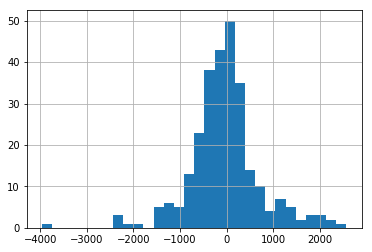

In [124]:
pd.Series(error).hist(bins=30)

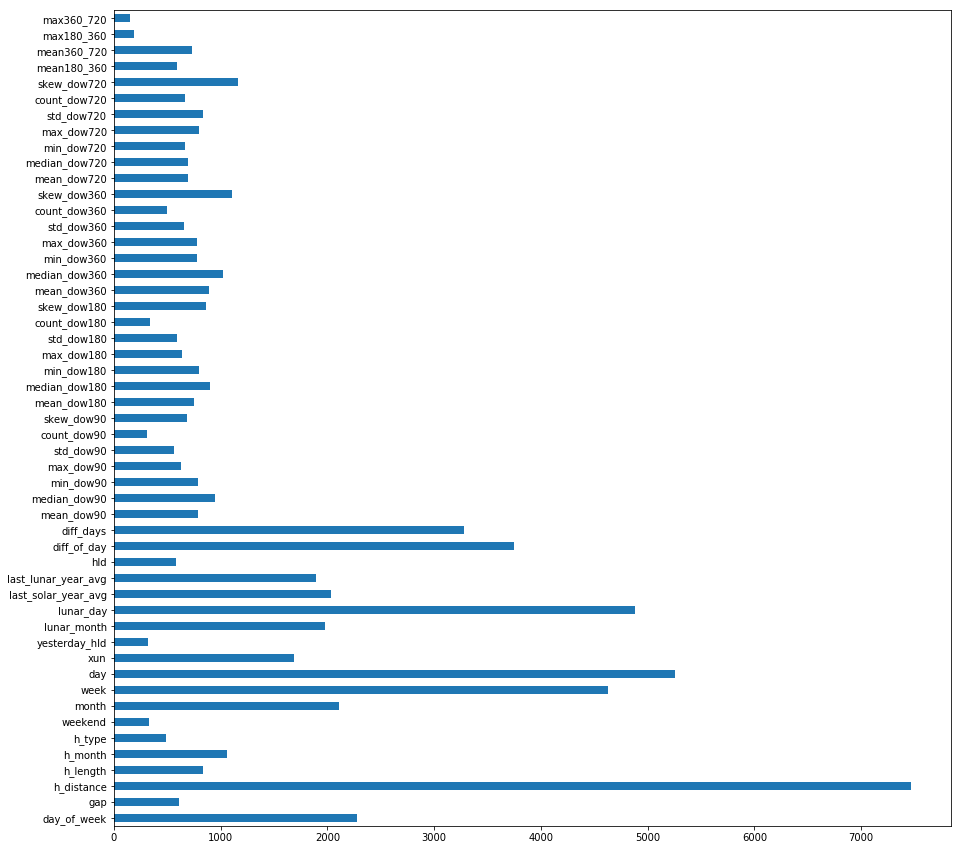

In [125]:
pd.Series(model1.feature_importances_, index=valid_X.columns).plot.barh(figsize=(15,15))

In [126]:
ppp = pd.DataFrame()
ppp['date']=valid_feat['virtual_date']
ppp['y']=predict_df['y']
ppp['true_value']=testy_df['y']
ppp['hld']=valid_feat['hld']
ppp['dow']=valid_feat['day_of_week']

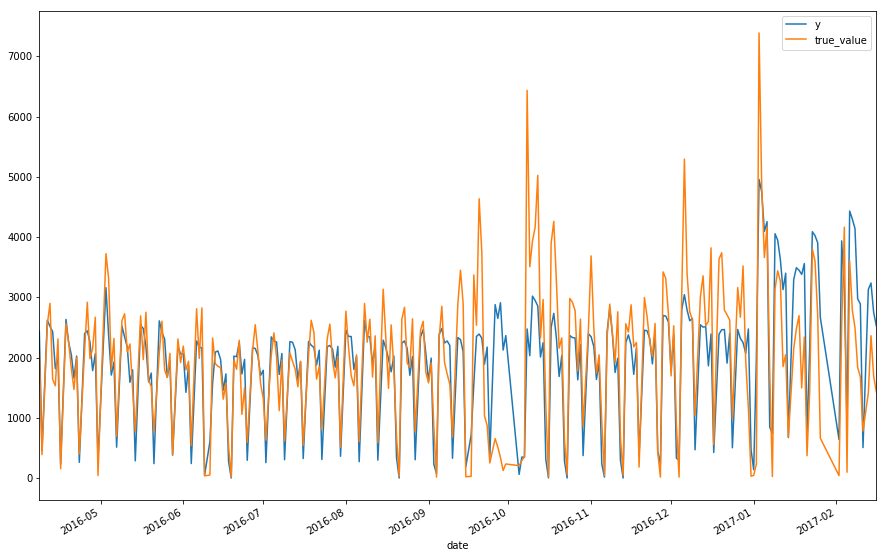

In [127]:
# pd.Series(testy_df['y']).plot(figsize=(15,10),x=ppp['date'])
# pd.Series(predict_df['y']).plot(figsize=(15,10),x=valid_feat['virtual_date'])
ppp.plot(x='date',y=['y','true_value'],figsize=(15,10))

In [128]:
ppp.to_csv('valid.csv',index=False)

## test

In [129]:
sliding_length = 100
predict_length = 315

train_feat = pd.DataFrame()
start_date = date(2017,2,17) # 315天 是 '2017-04-06' ，在往前推30天。

for i in range(101):
    if date_add_days(start_date, i*(-sliding_length)) < date_add_days(date(2013,1,1),120):
        break
    train_feat_sub = make_feats(date_add_days(start_date, i*(-sliding_length)), predict_length)  #120天是长度， 60是向后滑的天数，每次滑两个月
    train_feat = pd.concat([train_feat,train_feat_sub])

/Users/olivia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


In [130]:
test_feat = make_feats(df['virtual_date'].max()+DateOffset(days=1),285)

/Users/olivia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


In [131]:
print(train_feat['virtual_date'].min())
print(train_feat['virtual_date'].max())
print(test_feat['virtual_date'].min())
print(test_feat['virtual_date'].max())
print(train_feat.shape)

2013-01-02 00:00:00
2017-02-16 00:00:00
2017-02-17 00:00:00
2017-11-28 00:00:00
(3715, 57)


In [132]:
train_df = train_feat.drop(['virtual_date','start_date','date'], axis=1)    
test_df = test_feat.drop(['virtual_date','start_date','date'], axis=1)
train_X = train_df.drop(['cnt','year','lunar_year'], axis=1)
train_Y = train_df['cnt']
#test_X = df.iloc[train_index:,:].drop(['year','lunar_year','virtual_date','date','cnt'], axis=1) #这样写把 text_X 的空栏位去掉了，但是只剩下15个栏位，无法和 trainX 匹配
test_X = test_df.drop(['cnt','year','lunar_year'], axis=1)  # 这里前面数据滚完之后，会有很多 test_X 的栏位空值 影响结果

In [133]:
train_X[['last_solar_year_avg','last_lunar_year_avg']] = train_X[['last_solar_year_avg','last_lunar_year_avg']].fillna(train_X[['last_solar_year_avg','last_lunar_year_avg']].median())

In [134]:
train_feat.head()

,cnt,date,day_of_week,gap,virtual_date,h_distance,h_length,h_month,h_type,weekend,...,median_dow720,min_dow720,max_dow720,std_dow720,count_dow720,skew_dow720,mean180_360,mean360_720,max180_360,max360_720
0,2050.0,1033,5,1,2016-04-08,-4,3,4,0.0,0,...,1853.0,12.0,4838.0,828.775368,97.0,0.963215,1.191454,1.019671,1.000000,1.000000
1,388.0,1034,6,1,2016-04-09,-5,3,4,0.0,1,...,304.5,15.0,2489.0,399.326450,96.0,3.235490,1.133029,1.156740,0.628365,1.000000
2,2550.0,1035,1,2,2016-04-11,-7,3,4,0.0,0,...,2206.0,13.0,6421.0,1042.051630,96.0,1.437931,1.150198,1.080136,1.000000,1.000000
3,2899.0,1036,2,1,2016-04-12,-8,3,4,0.0,0,...,2344.0,15.0,7226.0,1099.750166,101.0,1.714018,1.149883,1.073191,1.000000,0.978273
4,1640.0,1037,3,1,2016-04-13,-9,3,4,0.0,0,...,1964.0,88.0,5017.0,866.427995,101.0,1.193655,1.176380,1.051331,1.000000,1.000000


In [135]:
predict = 0
bagging_num = 2
for i in range(bagging_num):
#     model1 = ensemble.ExtraTreesRegressor(n_jobs=-1, n_estimators=2000, max_depth=10, max_features=0.8,
#                                            min_samples_split = 5, random_state = i*3)
#     model1.fit(train_X.fillna(-1), train_Y)
#     predict +=  0.4*model1.predict(test_X.fillna(-1))
    
    model1 = LGBMRegressor(learning_rate=0.01, n_estimators=2000, subsample=0.7, num_leaves=30+i*5, 
                           colsample_bytree=0.3, random_seed = i*3)
    model1.fit(train_X.fillna(-1), train_Y)
    predict +=  model1.predict(test_X.fillna(-1))
    
#     model1 = LGBMRegressor(learning_rate=0.01, n_estimators=1000, subsample=0.6, num_leaves=60+i*5, 
#                            colsample_bytree=0.5, random_seed = i*3)
#     model1.fit(train_X.fillna(-1), np.log10(train_Y))
#     predict +=  0.1*np.power(10,model1.predict(valid_X.fillna(-1)))

#     model1 = CatBoostRegressor(iterations=1000, learning_rate=0.01, depth=5, l2_leaf_reg=1, loss_function='RMSE', 
#                            eval_metric='RMSE', logging_level='Silent', random_seed=i*5)
#     model1.fit(train_X.fillna(-1), train_Y)
#     predict += model1.predict(test_X.fillna(-1))

#     model1 = KNeighborsRegressor(n_jobs=-1, n_neighbors=20)
#     model1 = LinearRegression(n_jobs=-1)
#     model1.fit(train_X.fillna(-1), train_Y)
#     predict += 0.2*model1.predict(test_X.fillna(-1))
predict = predict/bagging_num/1


In [139]:
predict_df = pd.DataFrame()
predict_df['date'] = test_feat['date']
predict_df['y'] = predict
# predict_sum = predict_df.groupby(['date']).y.agg('sum')

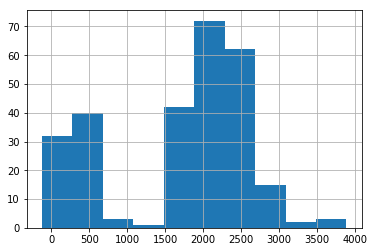

In [140]:
pd.Series(predict).hist()

In [141]:
ans = pd.Series(predict.astype(np.int), index=test_index)

In [142]:
ans.sort_index(inplace=True)
ans.head()

date
1308    2148
1309     501
1310     185
1311    2597
1312    2613
dtype: int64

In [143]:
ans.to_csv('predict_0226.txt',header=None,sep='\t')

In [82]:
ans.shape

(272,)

In [83]:
true_value = pd.read_table('answer_A_20180226.txt',encoding='gbk',sep='\t',header=None)

FileNotFoundError: File b'answer_A_20180226.txt' does not exist

In [ ]:
true_value[1].shape

In [ ]:
error = ans.values - true_value[1]
metric= np.mean(np.square(error))
print(metric)

In [ ]:
pd.Series(error).hist(bins=30)

In [ ]:
cols = ['day_of_week','gap','virtual_date','h_distance','h_length','yesterday_hld']

In [ ]:
test_feat.shape

In [ ]:
tmp_df = pd.DataFrame([{'day_of_week':0,'gap':0,
                                  'virtual_date':0,'h_distance':0,
                                  'h_length':0,'yesterday_hld':0}],columns=cols)

In [ ]:
tmp_df.head()

In [ ]:
test_feat[cols].head()

In [ ]:
ana_df = test_feat[cols].copy()
ana_df = pd.concat([tmp_df,ana_df], ignore_index=True)
ana_df['predict'] = ans.values
ana_df['error'] = error
ana_df['true_value'] = true_value[1]

In [ ]:
ana_df[abs(ana_df['error'])>2000]

In [ ]:
ans.mean()

In [ ]:
ans.plot()